### Abstract

The objective is to choose the best model for a given data, thus we need to make several models  with a portion of the data and evaluating the best model possible by choosing the one with the lowest SSE. After choosing the best model is necessary to create a new model with all training data avaiable in order to create outputs for the real data.

# Import Libraries

In [1]:
import numpy as np
import random
from matplotlib import pyplot as plt
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures,  StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, LassoCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, RepeatedKFold, GridSearchCV

# Import Train Data

In [132]:
N_list = 500
X_import = np.load("data/Xtrain_Regression1.npy")
Y_import = np.load("data/Ytrain_Regression1.npy")
# create global functions to store the splitted data
X_train,Y_train,X_test,Y_test, X_train_s, X_test_s,Y_train_s,Y_test_s = [], [], [], [], [], [], [], []

for i in range(N_list):
    result = train_test_split(X_import, Y_import, test_size=0.2)
    X_train.append(result[0])
    X_test.append(result[1])
    Y_train.append(result[2])
    Y_test.append(result[3])

    x_import = StandardScaler().fit_transform(X_import)
    result2 = train_test_split(x_import, Y_import, test_size=0.2)
    X_train_s.append(result[0])
    X_test_s.append(result[1])
    Y_train_s.append(result[2])
    Y_test_s.append(result[3])



# Essencial Functions

In [90]:
def split_data(x_import,y_import,test_siz):
    '''Splits the data according to the test_siz fraction'''
    x_train, x_test, y_train, y_test = train_test_split(x_import, y_import, test_size=test_siz)
    return (x_train,y_train,x_test,y_test)

def calc_SSE(y_pred,y):
    '''Calculates the SSE from the predicted data'''
    #return np.sum((y_pred - y)**2)
    return mean_squared_error(y_pred,y)*np.shape(y)[0]

def beta_from_model(model):
    '''Returns the complete beta matrix from the model'''
    beta = model.coef_[0]
    beta[0] = model.intercept_[0]
    return beta 

# Linear Model

In [99]:
def linear_model(x, y):
    '''Creates and returns a simple linear regression model of order 1'''
    LR = LinearRegression()
    LR.fit(x,y)
    return LR

def test_linear_model():
    '''Tests the linear model returning a simple SSE value'''

    SSE_lst = []

    for i in range(N_list):
        model_sl = linear_model(X_train[i], Y_train[i])
        y_pred = model_sl.predict(X_test[i])
        SSE_lst.append(calc_SSE(y_pred, Y_test[i]))

    SSE_avg = np.mean(SSE_lst)
    SSE_std = np.std(SSE_lst)

    return(SSE_avg,SSE_std)

SSE_lin = test_linear_model()
print("Average SSE :", SSE_lin[0], "+/-", SSE_lin[1])

Average SSE : 0.258843277191666 +/- 0.06988077731149227


# Polynomial Model

SSE order 1 : 0.2519532103011906 +/- 0.06649338529900284
SSE order 2 : 11.45672096048582 +/- 32.918354689637766
SSE order 3 : 30.26184857814894 +/- 10.759041285118451
SSE order 4 : 85.88651389300918 +/- 36.97230179810705


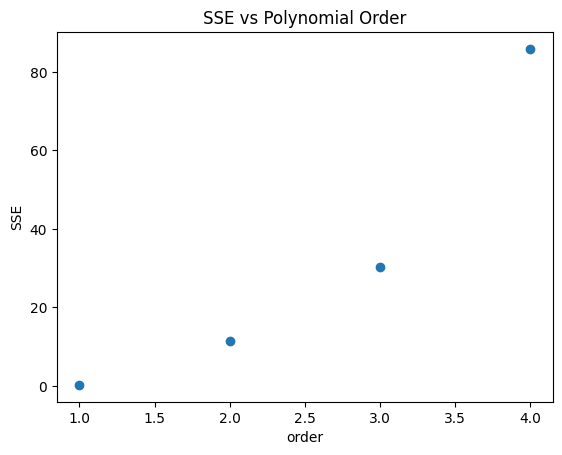

In [108]:
def polynomial_model(x, y, deg):
    '''Creates the polynomial model'''

    poly = PolynomialFeatures(degree=deg, include_bias=True)  
    poly_features = poly.fit_transform(x) 
    poly_reg_model = LinearRegression()  
    poly_reg_model.fit(poly_features, y)
    return poly_reg_model, poly

def test_polynomial_model(deg_max,show_plots=True):
    '''Tests the polynomial model up to deg_max'''

    order_list, SSE, SSE_plt = [i for i in range(1,deg_max+1)], [], []

    def get_avg_sse(i):
        '''Returns the average SSE for a given polynomial degree'''
        SSE_lst = []
        for s in range(N_list):
            (model,poly) = polynomial_model(X_train[s],Y_train[s],i)
            x_test_trans = poly.transform(X_test[s])
            y_pred = model.predict(x_test_trans)
            SSE_lst.append(calc_SSE(y_pred,Y_test[s]))
        return [np.mean(SSE_lst), np.std(SSE_lst)]
        

    for i in range(1,deg_max+1):
        SSE.append(get_avg_sse(i))
        SSE_plt.append(SSE[-1][0])
    
    
    if show_plots:
        plt.scatter(order_list, SSE_plt)
        plt.xlabel('order')
        plt.ylabel('SSE')
        plt.title('SSE vs Polynomial Order')
        
        return SSE, plt
    
    else:
        return SSE


SSE_pol, plot_pol = test_polynomial_model(4,show_plots=True)
for i in range(len(SSE_pol)):
    print("SSE order",i+1,":",SSE_pol[i][0], "+/-", SSE_pol[i][1])
plot_pol.show()

From the plot above we can see that a first order model is the best

# Ridge Model

In [126]:
def ridge_modelcv(x,y,cv):
    param = {
    # Uncoment just on list of alphas at a time and fine tune
    #'alpha':[0.0001, 0.001,0.01,1], #First Run select order -> 0.001 the best
    'alpha':(np.logspace(-3, -1, 50)), #At this range is random  -8,8
    #'fit_intercept':[True,False],
    #'solver':['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'] #,'lbfgs'
    }
    
    model = Ridge()
    search = GridSearchCV(model, param, scoring='r2', n_jobs=-1, cv=cv)
    result = search.fit(x, y)
    return result

def test_ridge_model(i,pt=True):
    '''This function tests the ridge model'''

    cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=1)
    model = ridge_modelcv(X_train_s[i],Y_train_s[i],cv)
    y_pred = model.predict(X_test_s[i])
    r2=model.best_score_
    sse=calc_SSE(y_pred,Y_test_s[i])
    mse=mean_squared_error(Y_test_s[i],y_pred)
    alpha=model.best_params_['alpha']

    if pt==True:
        print('R2: %s' % r2)
        print('SSE:',sse)
        print('MSE',mse)
        print('Best Hyperparameters: %s' % model.best_params_)
    return r2, sse, mse, alpha

best_alpha_ridge = test_ridge_model(0)[3]

R2: 0.9977242566153235
SSE: 0.26242664259655096
MSE 0.013121332129827547
Best Hyperparameters: {'alpha': 0.0517947467923121}


In [127]:
#Change True to False
if True:
    r2,mse = [], []
    for i in range(N_list):
        ridge_model = Ridge(alpha = 0.06) #,fit_intercept = True, solver = 'saga')
        model = ridge_model.fit(X_train_s[i],Y_train_s[i])
        y_pred = model.predict(X_test_s[i])
        r2.append(r2_score(Y_test_s[i],y_pred))
        mse.append(mean_squared_error(Y_test_s[i],y_pred))
    print("Average R2:", np.mean(r2),"+/",np.std(r2))
    print("Average MSE:", np.mean(mse),"+/",np.std(mse))

Average R2: 0.9976748089156094 +/ 0.0010313659544595745
Average MSE: 0.012687076520383488 +/ 0.0035864075017745696


# Lasso Model

In [129]:
def lasso_modelcv(x,y,cv):
    param = {
    # Uncoment just on list of alphas at a time and fine tune
    #'alpha':[0.0001, 0.001,0.01,1], #First Run select order -> 0.001 the best
    'alpha':(np.logspace(-3, 0, 50)), #At this range is random 
    #'fit_intercept':[True,False]
       }
    
    lasso = Lasso()
    search = GridSearchCV(lasso, param, scoring='r2' ,cv=cv)
    result = search.fit(x, y)
    return result

def test_lasso_model(i,pt=True):
    '''This function tests the ridge model'''

    cv = None#RepeatedKFold(n_splits=10, n_repeats=5, random_state=1)

    model = lasso_modelcv(X_train_s[i],Y_train[i],cv)
    y_pred = model.predict(X_test_s[i])
    r2=model.best_score_
    sse=calc_SSE(y_pred,Y_test[i])
    mse=mean_squared_error(Y_test[i],y_pred)
    alpha=model.best_params_['alpha']

    if pt==True:
        print('R2: %s' % r2)
        print('SSE:',sse)
        print('MSE',mse)
        print('Best Hyperparameters: %s' % model.best_params_)
    return r2, sse, mse, alpha

best_lasso_alpha=test_lasso_model(0)[3]

R2: 0.9977683778305073
SSE: 0.26375423415758525
MSE 0.013187711707879263
Best Hyperparameters: {'alpha': 0.004714866363457394}


In [130]:
#change False to True
if True:
    r2,mse = [], []
    for i in range(N_list):
        lasso_model = Lasso(alpha = best_lasso_alpha)
        model = lasso_model.fit(X_train_s[i],Y_train_s[i])
        y_pred = model.predict(X_test_s[i])
        r2.append(r2_score(Y_test_s[i],y_pred))
        mse.append(mean_squared_error(Y_test_s[i],y_pred))
    print("Average R2:", np.mean(r2),"+/",np.std(r2))
    print("Average MSE:", np.mean(mse),"+/",np.std(mse))

Average R2: 0.9976738893599402 +/ 0.0010601689009244054
Average MSE: 0.012706954756514885 +/ 0.0038809255437101432


# Comparing Linear, Ridge and Lasso

100%|██████████| 50/50 [09:20<00:00, 11.21s/it]


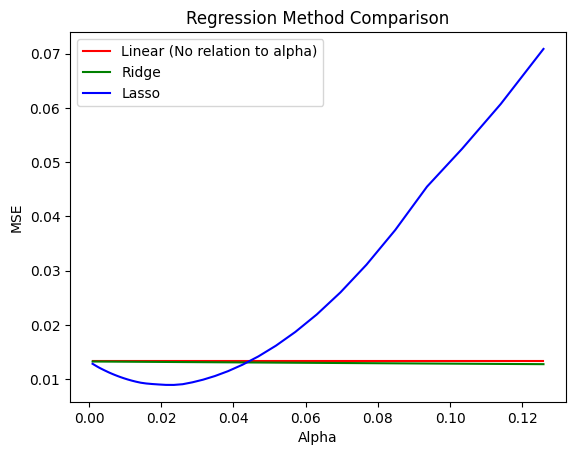

In [135]:
from tqdm import tqdm
def compare_lin_rid_las(alpha_list):
    MSE_ridge, MSE_lasso, MSE_linear = [], [], []
    for alpha in tqdm(alpha_list):

        for i in range(N_list):
         
            MSE_ridge_i, MSE_lasso_i, MSE_linear_i = [], [], []
            #Linear
            linear = LinearRegression()
            linear.fit(X_train[i],Y_train[i])
            y_linear = linear.predict(X_test[i])
            MSE_linear_i.append(mean_squared_error(Y_test[i],y_linear))

            #Ridge
            ridge = Ridge(alpha=alpha)
            ridge_model = ridge.fit(X_train_s[i],Y_train_s[i])
            y_ridge = ridge_model.predict(X_test_s[i])
            MSE_ridge_i.append(mean_squared_error(Y_test_s[i],y_ridge))

            # Lasso
            lasso = Lasso(alpha = alpha)
            lasso_model = lasso.fit(X_train_s[i],Y_train_s[i])
            y_lasso = lasso_model.predict(X_test_s[i])
            MSE_lasso_i.append(mean_squared_error(Y_test_s[i],y_lasso))

        MSE_linear.append(np.mean(MSE_linear_i))
        MSE_ridge.append(np.mean(MSE_ridge_i))
        MSE_lasso.append(np.mean(MSE_lasso_i))

    plt.plot(alpha_list, MSE_linear, color='r', label='Linear (No relation to alpha)')
    plt.plot(alpha_list,MSE_ridge, color='g', label='Ridge')
    plt.plot(alpha_list,MSE_lasso,  color='b', label='Lasso')

    # Naming the x-axis, y-axis and the whole graph
    plt.xlabel("Alpha")
    plt.ylabel("MSE")
    plt.title("Regression Method Comparison")
    
    # Adding legend, which helps us recognize the curve according to it's color
    plt.legend()
    
    # To load the display window
    plt.show()

compare_lin_rid_las(np.logspace(-3, -0.9, 50))

As we can see, we have a value for alpha where Ridge has the lowest MSE and consequently SSE

## Conclusions

Let's assume Ridge is the best model due to a marginal difference in SSE

In [10]:
x_eval_import = np.load("data/Xtest_Regression1.npy")
x_eval_s = StandardScaler().fit_transform(x_eval_import)
X_import_s = StandardScaler().fit_transform(X_import)
ridge = Ridge(alpha=best_alpha_ridge)
ridge_model = ridge.fit(X_import_s,Y_import)
y_ridge = ridge_model.predict(x_eval_s)


NameError: name 'ridge_model' is not defined

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=25889058-66de-44c8-ad64-ee695f6c1052' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>